---
# Module 4: Exemple de classification des données
---

Dans ce script en Python, nous allons montrer un exemple typique de classification utilisant une base de données réelles sur les vins rouges. 

L'idée est de montrer les différentes étapes que l'on doit réaliser pour en arriver à un résultat intéressant. Le but est de construire un classificateur permettant de déterminer si un vin est bon ou mauvais, en se basant sur l'expertise d'œnologues professionnels.

Nous allons montrer uniquement les étapes de traitements sélectionnées, après avoir essayé par essais et erreurs plusieurs combinaisons d'approches. La méthode permettant de déterminer les bonnes étapes de prétraitement est expliquée dans un autre tutoriel de ce cours.

De plus, nous allons n'utiliser qu'un seul classificateur, XGBoost, et n'allons pas l'optimiser; il fonctionne bien avec ses paramètres par défaut. La méthode systématique permettant d'optimiser un classificateur, ou plusieurs classificateurs en même temps, est expliquée dans un autre tutoriel de ce cours.


### Informations sur la base de données.

La base de données [Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) 
contient 12 variables, continues ou ordinales, qui ont été mesurées sur 4898 vins dégustés par au moins 
trois oenologues. Elle contient les résultats pour 1599 vins après le moyennage des résultats.
 
<p>&nbsp;</p>
<div align="center">
    <table><tr>
    <td> <img src= https://drive.google.com/uc?id=1p4MCOhwD6sfcbkyd-3UVT9D0P_pHJMf1  width="600" /> </td>
    <td> <img src= https://drive.google.com/uc?id=1Rv3ARXg35hzJnzGHVEDu-OLSrxQEwCTp  width="530" /> </td>
    </tr></table>    
    <div>
    <td>  <font size="1.5">Image Source: https://sanfranciscodrinksguide.com/en/blog/features-106/stories-110/usa-wine-ratings-your-personal-wine-guide-64.htm</font> </td>
    </div>
</div>
<p>&nbsp;</p>

Les variables suivantes ont été mesurées. Ce sont pour la plupart des concentrations chimiques de composants du vin.

<ul>
<li><b>Fixed acidity</b>: la plupart des acides présents dans le vin sont fixes ou non volatiles (ne s'évaporent pas facilement),</li>
<li><b>Volatile acidity</b>: la quantité d'acide acétique dans le vin, qui, à des niveaux trop élevés, peut donner un goût désagréable de vinaigre,</li>
<li><b>Citric acid</b>: présent en petites quantités, l'acide citrique peut ajouter de la fraîcheur et de la saveur aux vins,</li>
<li><b>Residual sugar</b>: la quantité de sucre restant après l'arrêt de la fermentation, il est rare de trouver des vins avec moins de 1 gramme/litre et les vins avec plus de 45 grammes/litre sont considérés comme doux,</li>
<li><b>Chlorides</b>: la quantité de sel dans le vin,</li>
<li><b>Free sulfur dioxide</b>: la forme libre du SO2 existe en équilibre entre le SO2 moléculaire (sous forme de gaz dissous) et l'ion bisulfite ; elle empêche la croissance microbienne et l'oxydation du vin,</li>
<li><b>Total sulfur dioxide</b>: quantité de formes libres et liées de S02 ; à faible concentration, le SO2 est généralement indétectable dans le vin, mais à des concentrations supérieures à 50 ppm, le SO2 devient évident au nez et au goût du vin,</li>
<li><b>Density</b>: la densité du vin est proche de celle de l'eau, en fonction du pourcentage d'alcool et de la teneur en sucre,</li>
<li><b>pH</b>: décrit l'acidité ou la basicité d'un vin sur une échelle allant de 0 (très acide) à 14 (très basique) ; la plupart des vins se situent entre 3 et 4 sur l'échelle du pH,</li>
<li><b>Sulphates</b>: un additif du vin qui peut contribuer au niveau de gaz sulfureux (S02), qui agit comme un antimicrobien et un antioxydant,</li>
<li><b>Alcohol</b>: le pourcentage d'alcool contenu dans le vin,</li>
<li><b>Quality</b>: variable de sortie (basée sur des données sensorielles, note entre 0 (mauvais) et 10 (excellents)).</li>
</ul>    
    
On désire créer un classificateur binaire permettant de prédire les bons vins, c.-à-d. ceux pour lesquels 
*Quality*>=7.


### Étapes de traitement des données
Dans ce qui suit, nous allons effectuer les étapes suivantes :
<ul>
<li>le traitement des valeurs manquantes,</li>
<li>la transformation des variables,</li>
<li>le traitement des valeurs aberrantes.</li>
</ul>


L’ensemble du jeu de données sera utilisé pour effectuer cette analyse exploratoire.

### IMPORTANT: Copie du notebook!

Vous devez faire une copie du notebook dans votre drive avant de l'exécuter, car les modifications dans le notebook original ne seront pas sauvegardées. Vous travaillerez ainsi dans la copie et non dans l'original.


Importation des fichiers à utiliser dans le tutoriel.

In [1]:
%%bash
git clone https://github.com/Cours-EDUlib/IVADO-AA.git
mv IVADO-AA/module_4/* ./
rm -r IVADO-AA

Cloning into 'IVADO-AA'...


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 KB 4.2 MB/s eta 0:00:00


In [3]:
%%capture
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from feature_engine.outliers import Winsorizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Pour la reproductibilité des résultats
np.random.seed(43)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

## Partie I: Prétraitement des données

#### Lecture des données

In [4]:
df = pd.read_csv('winequality-red.csv')

df.shape

(1599, 12)

Il y a environ 1600 données avec 11 variables d'entrées et une variable de sortie ('quality').

#### Affichage des 5 premières lignes du fichier.

In [5]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


On voit que toutes les valeurs sont numériques.

### Identification des valeurs manquantes

Les valeurs manquantes dans les bases de données sont souvent indiquées par NaN (<i>not a number</i>) 
ou par des zéros. 

#### Affichage du nombre de valeurs manquantes NaN dans le dataframe.

In [6]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Il n'y a aucune valeur de type NaN pour les variables mesurées.

#### Affichage des valeurs minimales pour chaque variable

Toutes les variables étant positives, les variables avec des valeurs minimales nulles peuvent révéler la présence de valeurs manquantes.

In [7]:
df.min()

fixed acidity           4.60000
volatile acidity        0.12000
citric acid             0.00000
residual sugar          0.90000
chlorides               0.01200
free sulfur dioxide     1.00000
total sulfur dioxide    6.00000
density                 0.99007
pH                      2.74000
sulphates               0.33000
alcohol                 8.40000
quality                 3.00000
dtype: float64

La variable *citric acid* a une valeur minimale nulle. Est-ce réaliste ou est-ce que cela indique la présence de valeurs manquantes? 

#### Affichage de l'histogramme des valeurs de la variable 'citric acid'.

<AxesSubplot:xlabel='citric acid', ylabel='Count'>

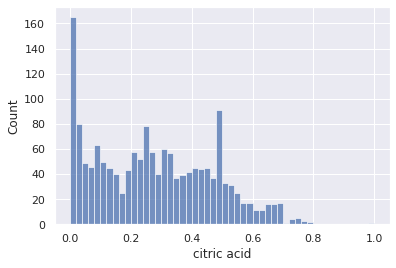

In [8]:
sns.histplot(data=df, x="citric acid", bins=50)

Il semble réellement y avoir un excès de valeurs nulles. Toutefois, la valeur minimale de 0 apparaît dans l'[article original](https://www.scitepress.org/Papers/2015/55519/55519.pdf) et les auteurs ne parlent pas de données manquantes. Les valeurs nulles correspondent à des vins pour lesquels la concentration en acides fruités est négligeable.

ATTENTION: il ne faut pas éliminer systématiquement les données ayant une valeur minimale nulle pour des variables entièrement positives ou négatives. On en voit ici un bon exemple.

### Exploration des données

#### Affichage de l'histogramme de la variable à prédire

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

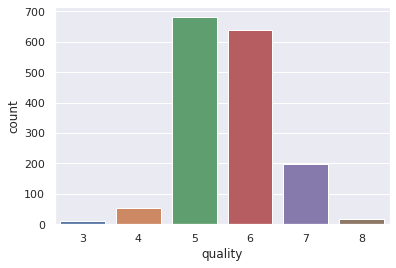

In [9]:
sns.countplot(df['quality'])
df['quality'].value_counts()

La majorité des vins ont une qualité autour de 5 et 6. Le classificateur devra détecter les bons vins, c.-à-d. ceux pour 
lesquels *quality*>=7.

#### Affichage des variables les plus faciles à interpréter

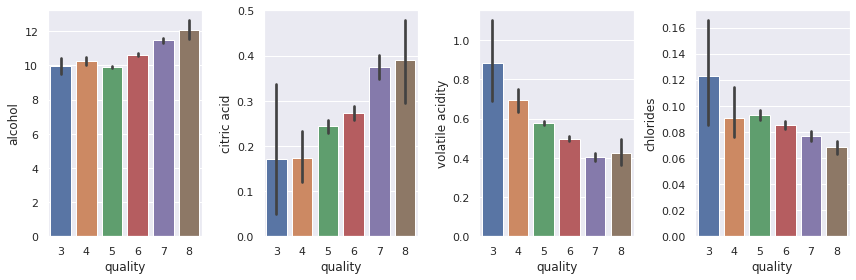

In [10]:
features = ['alcohol', 'citric acid', 'volatile acidity', 'chlorides']

fig = plt.figure(figsize=(12, 4))
for i, var in enumerate(features):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='quality', y=var, data=df)

plt.tight_layout()

Les meilleurs vins contiennent les plus hauts taux d'alcool et d'acidité fruitée, et les plus faibles taux de vinaigre (*volatile acidity*) et de sels (*chlorides*). 

#### Calcul et affichage de la matrice de corrélation

Cette matrice est un bon outil pour détecter 

<ul>
<li>les entrées fortement corrélées entre elles,</li>
<li>la corrélation entre les variables d'entrées et la réponse à prédire.</li>
</ul>

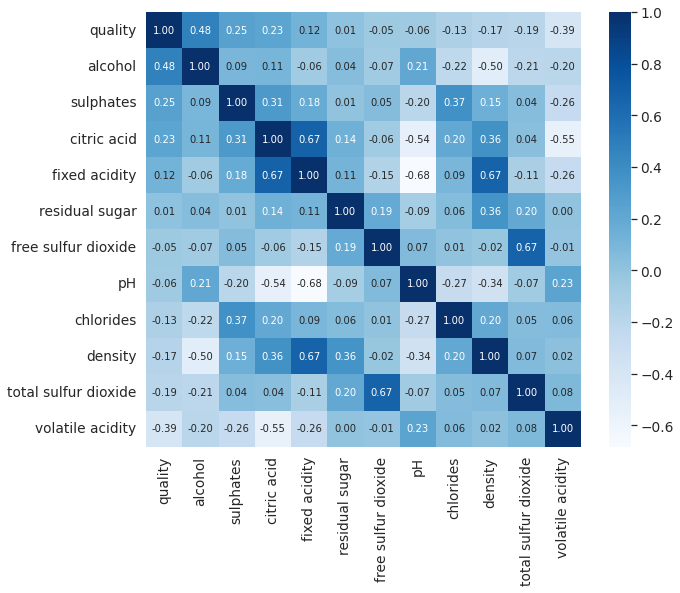

In [11]:
corr = df.corr()

nvar = len(df.columns)

plt.figure(figsize=(10, 8))
cols = corr.nlargest(nvar, 'quality')['quality'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap="Blues")
plt.show()

Plusieurs variables d'entrée sont fortement corrélées entre elles (par exemple celles reliées à l'acidité). Il est parfois utile de laisser tomber plusieurs d'entre elles afin d'augmenter les performances d'un classificateur. Ce n'était pas le cas avec ce jeu de données.

#### Affichage de la corrélation entre la réponse à prédire ('quality') et chacune des variables d'entrée

<AxesSubplot:>

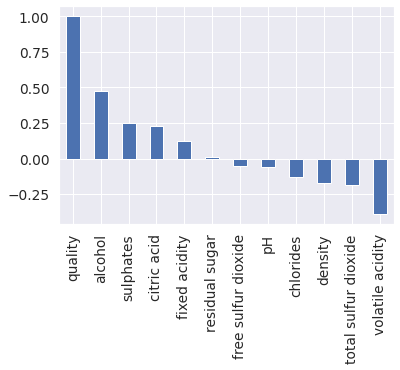

In [12]:
correlations = df.corr()['quality'].sort_values(ascending=False)
correlations.plot(kind='bar')

In [13]:
print(correlations)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


Sept variables d'entrée sur 11 sont faiblement corrélées avec la sortie (|corr|<0.2)

Il est parfois utile d'en laisser tomber plusieurs ou d'utiliser une méthode de réduction de la dimensionnalité (par exemple l'[ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales#:~:text=L%27%20analyse%20en%20composantes%20principales%20%28ACP%20ou%20PCA,en%20nouvelles%20variables%20d%C3%A9corr%C3%A9l%C3%A9es%20les%20unes%20des%20autres.)) pour augmenter les performances d'un classificateur. Ce n'était pas le cas avec ce jeu de données.

### Transformation des variables

#### Séparation des noms de variables en entrées X et en sorties Y.

In [14]:
Xcol = df.drop(['quality'], axis=1).columns.to_list()
Ycol = 'quality'

#### Définition d'une fonction affichant l'histogramme et la boîte à moustache (*bar plot*) pour une variable donnée.

In [15]:
def affiche_distributions(df, variable):

    plt.figure(figsize=(15, 2))

    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, color='r')
    plt.title(variable)

    plt.subplot(1, 2, 2)
    sns.boxplot(y = df[variable], color='r')
    plt.title('Boxplot')
    
    plt.show()

#### Affichage des histogrammes et des boîtes à moustaches pour les valeurs originales des variables

Examinons les variables afin de déceler la présence de valeurs aberrantes. 

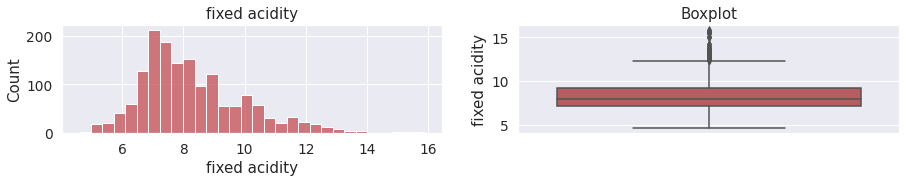

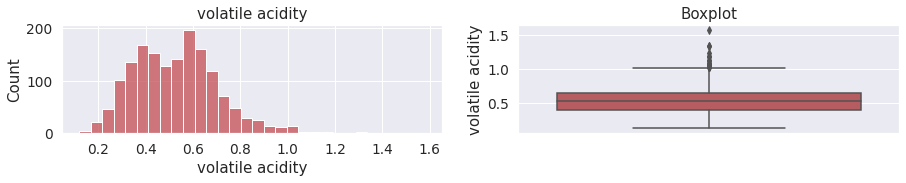

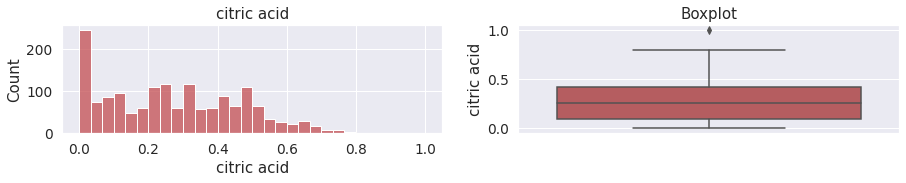

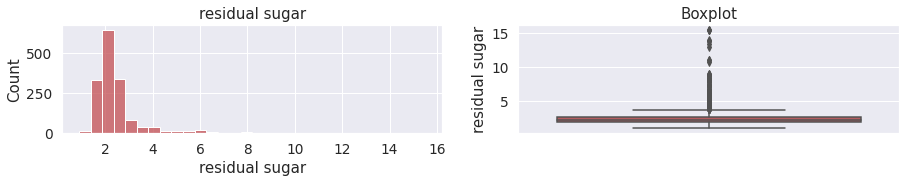

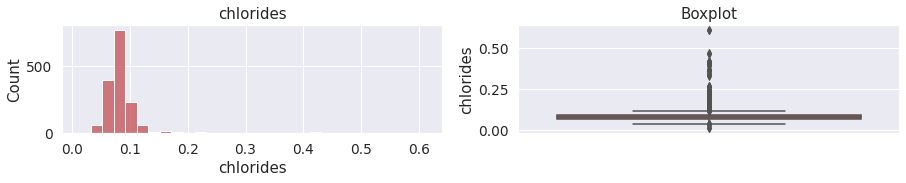

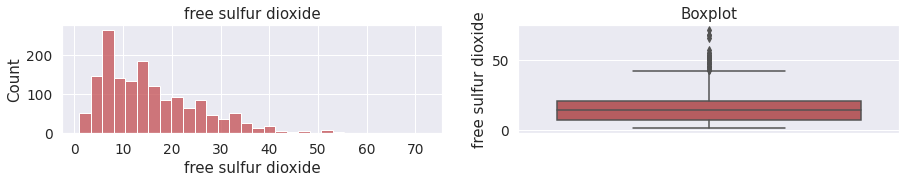

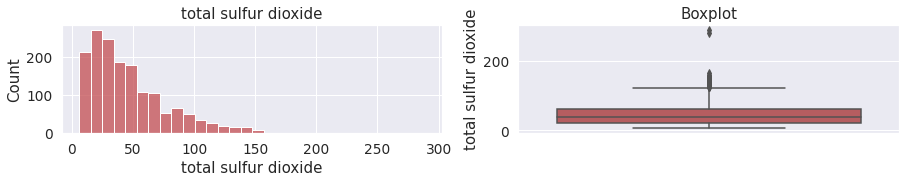

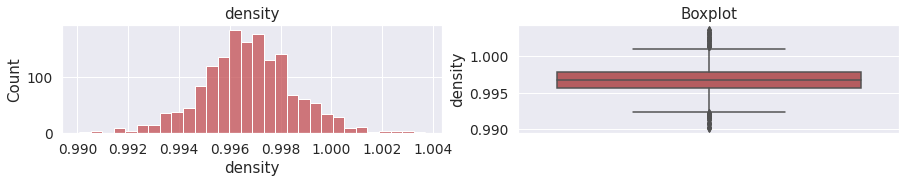

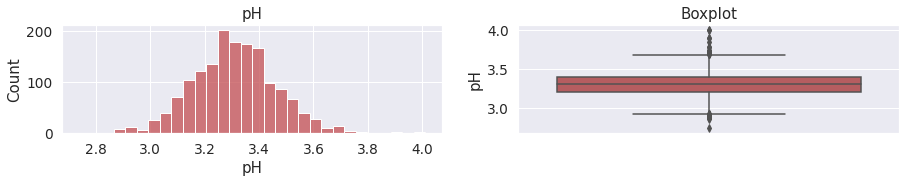

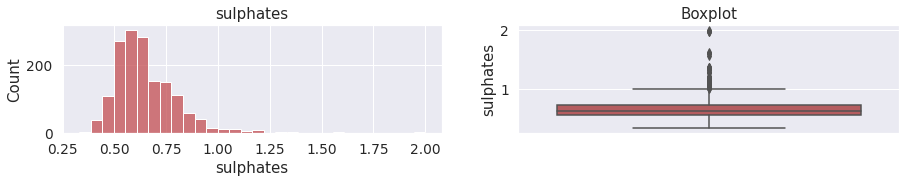

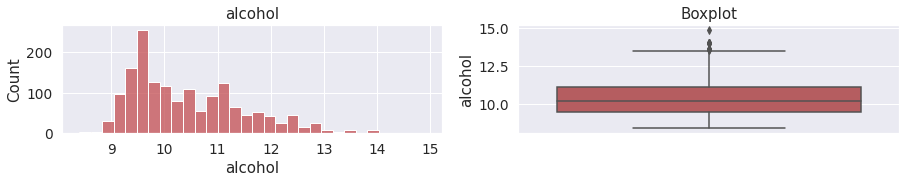

<Figure size 432x288 with 0 Axes>

In [16]:
for variable in Xcol:
    affiche_distributions(df, variable)
plt.tight_layout()

Les histogrammes montrent des distributions variées avec un étirement vers les données positives (*positive skewness*). On y observe plusieurs valeurs aberrantes. 

Les boîtes à moustaches identifient les valeurs aberrantes par des points. Attention toutefois, ces boîtes font l'hypothèse que les données ont des distributions gaussiennes, ce qui n'est pas toujours le cas comme ici. Plusieurs distributions peuvent naturellement être étirées sans valeurs aberrantes. C'est pourquoi il arrive souvent qu'on les transforme en distributions plus près d'une gaussienne. 

On utilise la transformation [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) à cette fin. Toutes les variables sauf
*citric acid*, *density* et *pH* sont transformées; ces dernières ont des distributions relativement uniformes ou normales.

In [17]:
features = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
       'sulphates', 'alcohol']

QT = QuantileTransformer(output_distribution='normal').fit(df[features])
df[features] = QT.transform(df[features])

#### Affichage des histogrammes et des boîtes à moustaches pour les valeurs transformées des variables

Examinons à nouveau les variables afin de déceler la présence de valeurs aberrantes dans les nouvelles distributions.

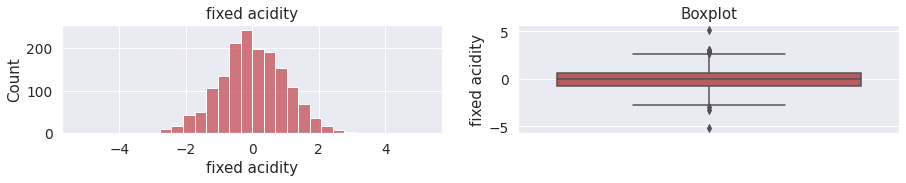

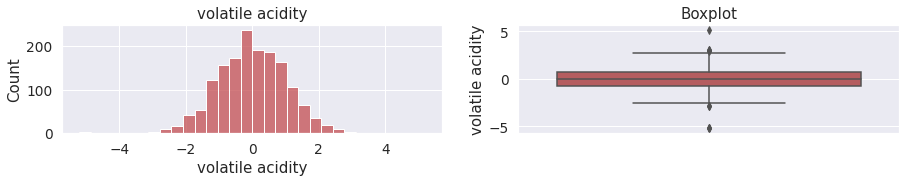

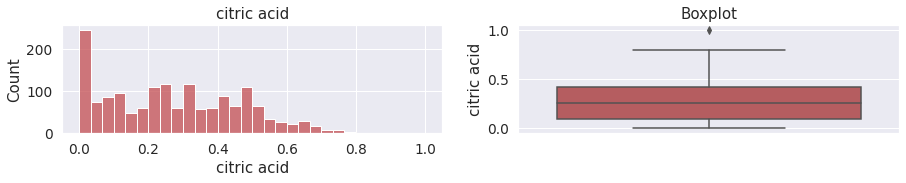

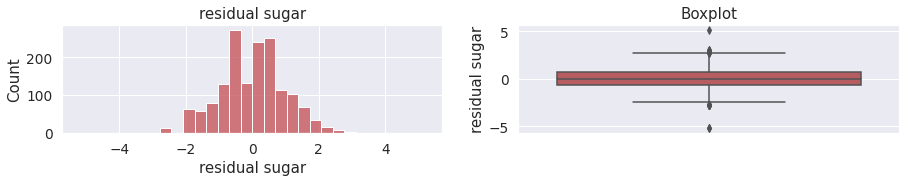

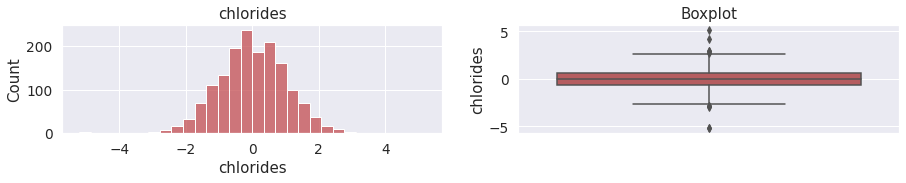

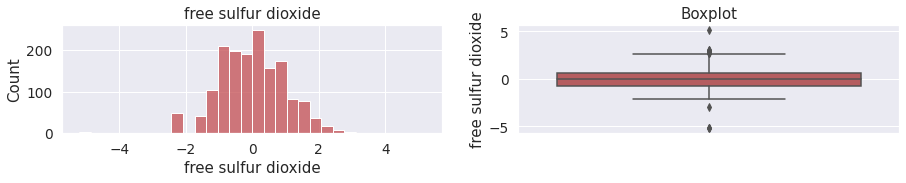

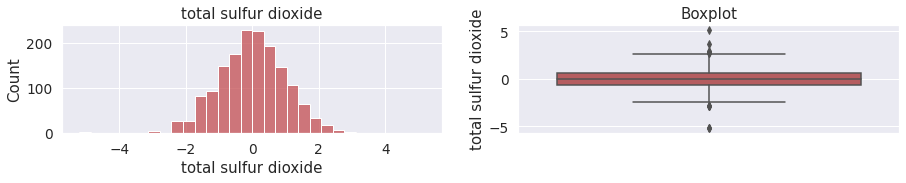

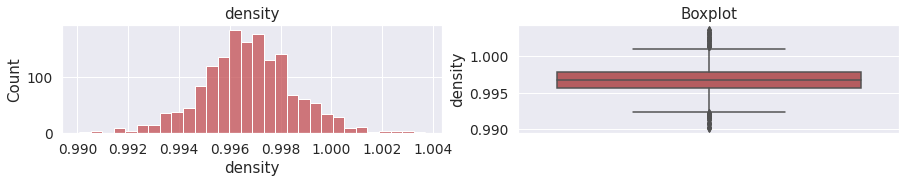

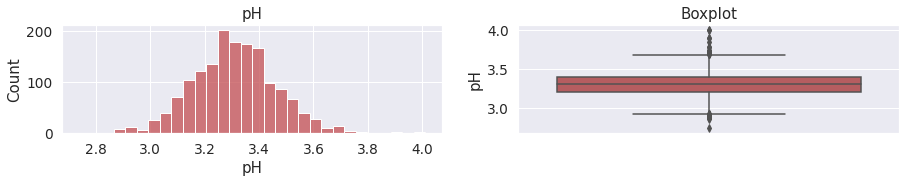

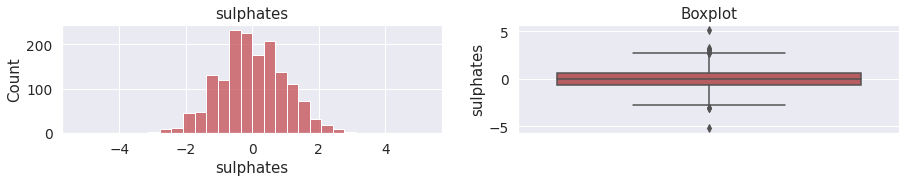

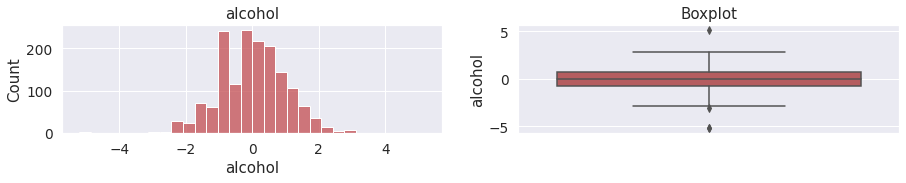

<Figure size 432x288 with 0 Axes>

In [18]:
for variable in Xcol:
    affiche_distributions(df, variable)
plt.tight_layout()

Les valeurs aberrantes sont maintenant distribuées de part et d'autre des boîtes à moustache.

### Traitement des valeurs aberrantes 

Puisque chaque variable a une distribution simple et non multimodale, on pourrait utiliser la méthode classique basée sur 
l'[intervalle interquartile](https://en.wikipedia.org/wiki/Interquartile_range) pour localiser et éliminer les valeurs aberrantes. Cela réduirait toutefois le nombre de données.

La [winsorisation](https://fr.wikipedia.org/wiki/Winsorisation) est une approche qui transforme les valeurs aberrantes, identifiées par la méthode IQR, afin de limiter leur impact dans l'estimation de paramètres. On n'élimine plus les valeurs aberrantes, on les transforme. 

In [19]:
windsoriser = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=Xcol)
windsoriser.fit(df[Xcol])

df[Xcol] = windsoriser.transform(df[Xcol])

#### Affichage des histogrammes et des boîtes à moustaches sans valeurs aberrantes

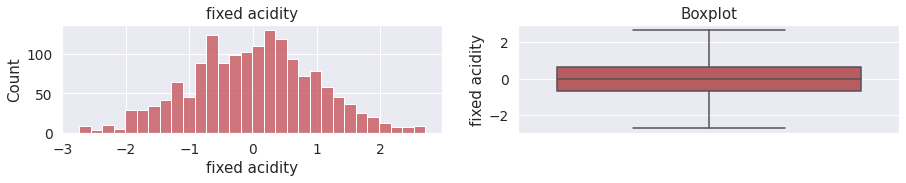

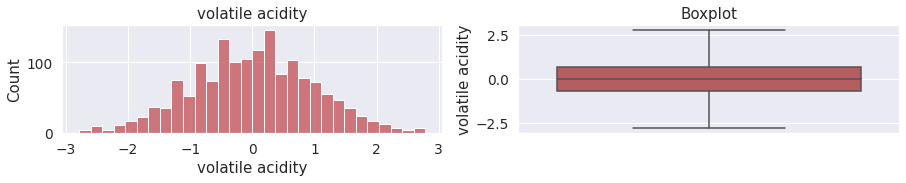

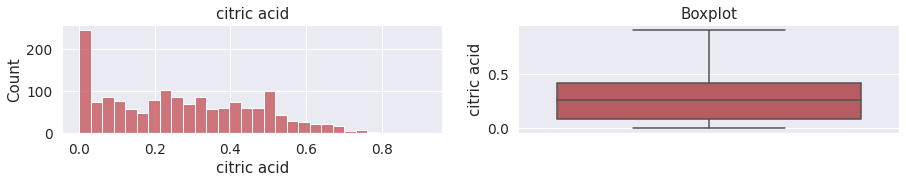

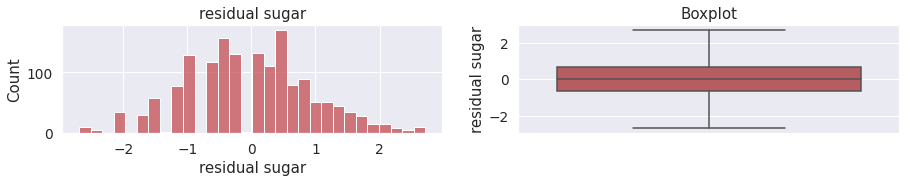

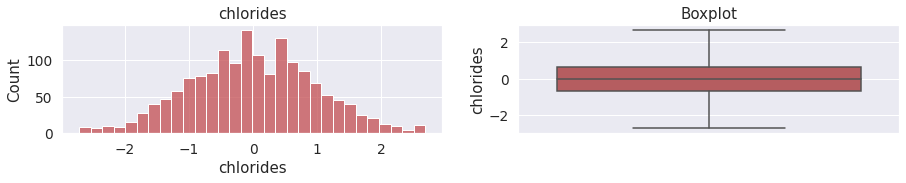

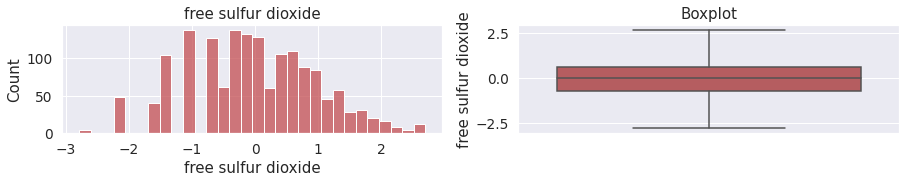

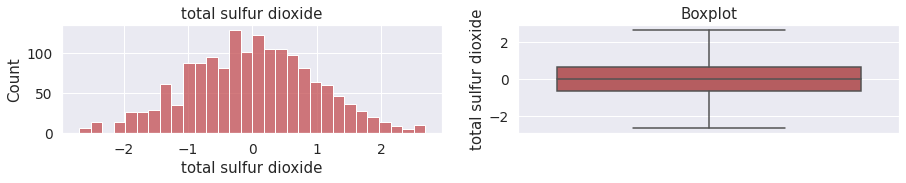

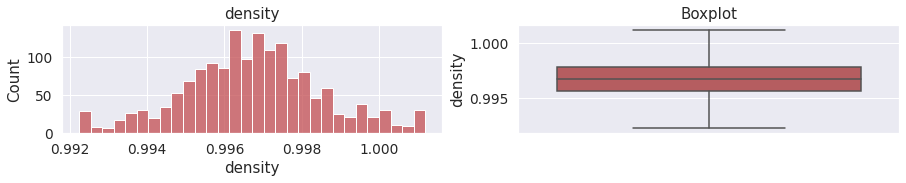

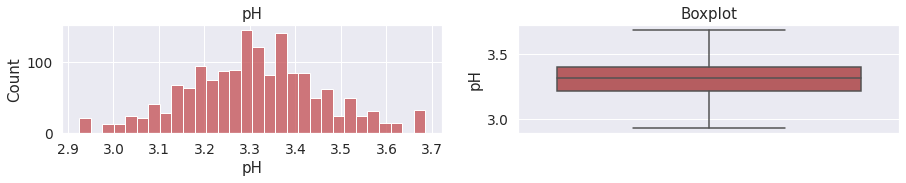

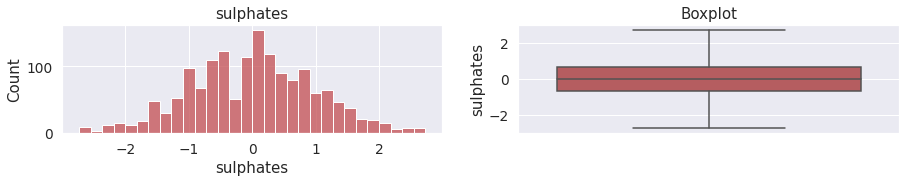

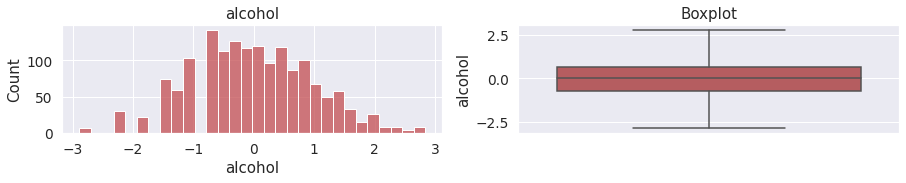

<Figure size 432x288 with 0 Axes>

In [20]:
for variable in Xcol:
    affiche_distributions(df, variable)
plt.tight_layout()

Il n'y a plus de valeurs aberrantes. 

### Codage de la réponse

Le niveau d'appréciation du vin (*quality*) varie entre 3 (mauvais) et 8 (excellent). On définit arbitrairement le seuil d'un bon vin à 7. La variable *quality* est encodée avec les valeurs 0 (mauvais vin) et 1 (bon vin).

In [21]:
df['quality'] = df['quality'].apply(lambda y_value: 1 if y_value>=7 else 0)

## Partie II: Entraînement d'un classificateur

#### Séparation des données en ensembles d'entraînement (80 %) et de test (20 %).

In [22]:
X = df[Xcol]
y = df[Ycol]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Balancement des classes.


<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=1CkiK7oblwxeRDNXF_iCDlIhG7vq6CpTG  width="200" />
    <div>
    <font size="1.5">Image Source: https://pixabay.com/illustrations/libra-pan-weigh-kitchen-scale-2071314//</font>
    </div>
</div>
<p>&nbsp;</p>


Il arrive souvent dans une base de données que la classe qui nous intéresse le plus soit la plus rare; il 
y a alors un débalancement entre les classes 

Affichons le nombre de sujets dans chaque classe pour les **données d'entraînement.**

In [24]:
n = y_train.value_counts()

print('Fraction de la classe minoritaire: %2.0f%%' % (100 * n[1] / (n[0] + n[1])))

Fraction de la classe minoritaire: 14%


Le débalancement est non négligeable, mais pas très important (environ 1/7). 

On pourrait balancer les deux classes en utilisant une méthode telle que [SMOTE](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html). 

Toutefois, lorsque le débalancement n'est pas très grand, l'augmentation de données change peu de choses et peut même réduire légèrement les métriques d'intérêt (précision, rappel, F score) d'un classificateur. Dans le doute, on peut l'entraîner avec ou sans augmentation de données et choisir le modèle final ayant les meilleures valeurs de précision et de rappel.

Dans ce script, on ne balance pas les classes afin de maximiser les métriques d'intérêt. 

**EXERCICE**: Décommentez et exécutez les instructions de la cellule suivante afin de voir l'effet du balancement des classes sur les performances du classificateur. Examinez le rapport de classification selon les classes. Quelles conclusions en tirez-vous?

In [25]:
# smote = SMOTE(sampling_strategy='minority')
# X_train, y_train = smote.fit_resample(X_train, y_train)

### La normalisation des données.


<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=1XDjy_EHwBlDcowJwDQSEE0VduUS7fFNv  width="300" />
    <div>
    <font size="1.5">Image Source: https://www.chegg.com/learn/nutrition/nutrition/body-shape-of-infants</font>
    </div>
</div>
<p>&nbsp;</p>


La dernière étape consiste à normaliser les données; on utilise la méthode [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). La normalisation des données X les met toutes sur un pied d'égalité (sans échelles, unités, etc.). L'étape de normalisation peut avoir un grand effet sur les performances des classificateurs. Certains classificateurs y sont sensibles, d'autres non. C'est une bonne habitude de l'utiliser par défaut.

On entraîne la méthode de transformation avec les données d'entraînement et on l'applique ensuite aux données d'entraînement et de test.

In [26]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### Entraînement d'un modèle

Nous allons utiliser un classificateur de type [XGBoost](https://xgboost.readthedocs.io/en/latest/); ses performances surpassent souvent celles des autres classificateurs avec des données tabulaires.

#### Initialisation

Les hyperparamètres du classificateur ne sont pas optimisés pour ce jeu de données; néanmoins, ils marchent plutôt bien comme on va le voir.

In [27]:
clf = XGBClassifier(reg_alpha=1, reg_lambda=0, use_label_encoder=False)

#### Entraînement

In [28]:
clf.fit(X_train_s, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Évaluation des performances

In [29]:
y_pred = clf.predict(X_test_s)

Affichage du rapport de classification selon les classes.

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       283
           1       0.81      0.68      0.74        37

    accuracy                           0.94       320
   macro avg       0.88      0.83      0.85       320
weighted avg       0.94      0.94      0.94       320



La première colonne contient les chiffres 0 et 1; elle identifie les résultats pour les bons (1) et les mauvais (0) vins.

Observations:
<ul>
<li>94% des prédictions (bons ou mauvais vins) sont correctes (exactitude ou <i>accuracy</i> en anglais).</li>
<li>81 % des bons vins sont prédits correctement (précision).</li>
<li>68% des bons vins sont identifiés (rappel ou <i>recall</i> en anglais).</li>
<li>Presque 100% des mauvais vins sont identifiés! Est-ce vraiment surprenant?</li>
</ul>

L'exactitude n'est pas très utile dans ce contexte puisqu'on veut déterminer si un vin est bon. On ne s'intéresse pas à la précision de détecter les bons et les mauvais vins puisqu'il est facile de détecter ces derniers.

### Faire une prédiction pour un vin à la fois

Beaucoup d'exemples sur le web montrent comment optimiser les performances d'un classificateur ou de plusieurs en même temps afin de sélectionner le meilleur d'entre eux. Toutefois, ils ne montrent presque jamais comment utiliser ensuite ce classificateur sur de nouvelles données.

La cellule suivante montre un exemple d'utilisation avec les données pour un nouveau vin à évaluer. On a mesuré sur celui-ci les mêmes paramètres chimiques que précédemment.

In [31]:
df2 = pd.DataFrame({    
    'fixed acidity' :  7.8,
    'volatile acidity' :  0.3, 
    'citric acid' : 0.2, 
    'residual sugar' : 2.0, 
    'chlorides' :  0.04,
    'free sulfur dioxide' : 9.0, 
    'total sulfur dioxide' : 18.0,
    'density' : 0.9968,
    'pH' :  3.36,
    'sulphates' : 0.57,  
    'alcohol' :  11}, index=[0])


# Transformation quantile des variables (prétraitement)
df2[features] = QT.transform(df2[features])

# Traitement des valeurs aberrantes
X = df2[Xcol]
X = windsoriser.transform(X)

# Normalisation des variables (prétraitement)
X_s = scaler.transform(X)

y_pred = clf.predict(X_s)

if (y_pred[0]==1):
  print('Bon vin!')
else:
  print('Mauvais Vin...')

Bon vin!
